# Load the data

In [1]:
import gc
from src.training.pretrainedModels import get_pretrained_model
from src.colors import bcolors
from config import Config

c = bcolors()
config = Config()
PRETRAINED_MODEL = "resnet50_RGB_MOCO"

In [2]:
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
import pandas as pd

from src.training.pretrainedModels import get_pretrained_model
from src.pickle_loader import save_object

CHANNELS = [3, 2, 1]
NUM_CLASSES = 10
NUM_AUG = 1

_, transform = get_pretrained_model(PRETRAINED_MODEL)

df = pd.read_csv(config.TRAIN_FILE)

encoder = OneHotEncoder()
encoder = encoder.fit(df[['label']].values.reshape(-1, 1))
save_object(encoder, config.DATA_DIR + "on_hot_encoder")


In [3]:
mean_std_S2C = {
    'mean': [1373.1, 1322.3, 1397.6],
    'std': [1144.9, 878.7, 854.3]
}

In [4]:
from sklearn.model_selection import train_test_split
from src.datasets.EuroSatMS import EuroSatMS

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])
print(df['label'].unique())
test_df, val_df = train_test_split(val_df, test_size=0.7)

ds_train = EuroSatMS(
    train_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS,
    transform=transform,
    mean_std=mean_std_S2C
)

ds_val = EuroSatMS(
    val_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS,
    transform=transform,
    mean_std=mean_std_S2C
)

ds_test = EuroSatMS(
    test_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS,
    transform=transform,
    mean_std=mean_std_S2C
)

print(f"""\n{c.OKGREEN}Train dataset:      {len(ds_train)} samples{c.ENDC}""")
print(f"""{c.OKGREEN}Validation dataset: {len(ds_val)} samples{c.ENDC}""")
print(f"""{c.OKGREEN}Test dataset:       {len(ds_test)} samples{c.ENDC}""")

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']

Preloading images...

Images:         21600
Augmentations:  21600
Jobs:           -4 

Time taken:      1 min 6.155768394470215 sec 

Preloading images...

Images:         3780
Augmentations:  3780
Jobs:           -4 

Time taken:      0 min 2.5485751628875732 sec 

Preloading images...

Images:         1620
Augmentations:  1620
Jobs:           -4 

Time taken:      0 min 1.423760175704956 sec 

Train dataset:      21600 samples
Validation dataset: 3780 samples
Test dataset:       1620 samples


In [5]:
import numpy as np

ii = ds_test[0][0]

print(ii[0])
print(ds_train.process_image(0)[0])

print(ii.shape)
print(np.mean(ii.numpy(), axis=(1, 2)))

tensor([[-1.0695, -1.0825, -1.0932,  ...,  0.9833,  1.0170,  1.0611],
        [-1.0666, -1.0826, -1.0961,  ...,  0.9334,  0.9716,  1.0184],
        [-1.0655, -1.0849, -1.1011,  ...,  0.9009,  0.9446,  0.9943],
        ...,
        [-1.2108, -1.2170, -1.2221,  ...,  1.3049,  1.2987,  1.2934],
        [-1.2333, -1.2373, -1.2395,  ...,  1.3099,  1.3009,  1.2924],
        [-1.2578, -1.2592, -1.2581,  ...,  1.3150,  1.3032,  1.2917]])
[[[0.         0.         0.         ... 0.65789473 0.65789473 0.6447368 ]
  [0.         0.         0.         ... 0.65789473 0.65789473 0.6447368 ]
  [0.         0.         0.         ... 0.67105263 0.67105263 0.6315789 ]
  ...
  [0.03947368 0.03947368 0.05263158 ... 0.09210526 0.05263158 0.05263158]
  [0.05263158 0.05263158 0.03947368 ... 0.09210526 0.07894737 0.05263158]
  [0.05263158 0.05263158 0.03947368 ... 0.06578948 0.10526316 0.06578948]]

 [[0.10526316 0.10526316 0.09210526 ... 0.5131579  0.5394737  0.5263158 ]
  [0.10526316 0.10526316 0.09210526 ... 

In [5]:
import kornia.augmentation as K
from torch import nn

p1, p2, p3 = 0.5, 0.75, 0.4
augmentation = nn.Sequential(
    K.RandomHorizontalFlip(p=p1),
    K.RandomVerticalFlip(p=p1),
    K.RandomAffine(degrees=30, translate=None, scale=None, shear=None, resample="nearest", padding_mode=2, p=p2),
    K.RandomShear(shear=0.2, resample="nearest", padding_mode=2, p=p2),
    K.RandomBrightness((0.5, 1.5), p=p2),
    K.RandomContrast(contrast=(0.6, 1.4), p=p2),
    K.RandomSaturation((0.7, 1.3), p=p2),
    K.RandomPlasmaContrast(roughness=(0.1, 0.4), p=p3),
    # K.RandomSolarize(thresholds=0.1, p=p3),
    # K.RandomSharpness(sharpness=(0.1, 0.3), p=p3),
    # K.RandomBoxBlur(kernel_size=(3, 3), p=p1),
    # K.RandomEqualize(p=p1),
    K.CenterCrop(size=(64, 64)),
)

ds_train.augment = augmentation
ds_val.augment = augmentation
ds_test.augment = None

# CNN Model Training

In [ ]:
import numpy as np
from src.training.data import EuroSatDataModule

BATCH_SIZE = 32
data_module = EuroSatDataModule(ds_train, ds_val, ds_test, BATCH_SIZE)
print(f"""{c.OKGREEN}Initialized the data module...{c.ENDC}""")

KERNEL_SIZE = [5, 3]
LEARNING_RATE = 0.03
MOMENTUM = 0.9
GAMMA = 0.9
DROPOUT = 0.3
EPOCHS = 15
CKPT_PATH = 'checkpoints/cnn/'
CLASS_WEIGHTS = {'AnnualCrop': 9,
                 'Forest': 9,
                 'HerbaceousVegetation': 8, 
                 'Highway': 9, 
                 'Industrial': 9,
                 'Pasture': 9, 
                 'PermanentCrop': 9, 
                 'Residential': 9, 
                 'River': 9, 
                 'SeaLake': 9}

w = np.array(list(CLASS_WEIGHTS.values()))
w_min, w_max = w.min(), w.max()
w = (w - w_min) / (w_max - w_min)

fname = "cnn_c"
for c in CHANNELS:
    fname += str(c)
fname += "_k"
for k in KERNEL_SIZE:
    fname += str(k)
fname += "_lr" + str(LEARNING_RATE)
fname += "_m" + str(MOMENTUM)
fname += "_g" + str(GAMMA)
fname += "_d" + str(DROPOUT)

print("Model name: ", fname)

In [ ]:
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from datetime import datetime

from src.training.cnn import LitEuroSatCnn

lightning_model = LitEuroSatCnn(
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE, 
    num_channels=len(CHANNELS), 
    kernel_size=KERNEL_SIZE,
    momentum=MOMENTUM,
    gamma=GAMMA,
    weights=torch.tensor(w, dtype=torch.float32),
    dropout=DROPOUT
)

logger = WandbLogger(
    project="eurosat_cnn",
    name="cnn_v1",
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    filename=fname + '_{epoch:02d}-{val_loss:.2f}',
    save_top_k=2, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=EPOCHS,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(lightning_model, datamodule=data_module)

In [ ]:
import torchmetrics
import matplotlib.pyplot as plt

trainer.test(lightning_model, datamodule=data_module, ckpt_path=checkpoint_callback.best_model_path)
metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)
all_preds = np.concatenate(lightning_model.ep_out)
all_true = np.concatenate(lightning_model.ep_true)
true_ep = torch.tensor(all_true)
pred_ep = torch.tensor(all_preds)
metric.update(pred_ep, true_ep)
fig, ax = metric.plot()
plt.show()
print(encoder.categories_[0])

# Pretrained Model Training
### Training Phase 1
##### Pretrained ResNet50, ResNet18, AlexNet, ViT Model

In [40]:
import torch
from tabulate import tabulate
from src.training.pretrainedModels import get_pretrained_model
from src.training.data import EuroSatDataModule
from src.training.pretrainedModels import EuroSatPreTrainedModel

BATCH_SIZE = 64
CKPT_PATH = f'checkpoints/{PRETRAINED_MODEL}/'

model, _ = get_pretrained_model(PRETRAINED_MODEL)

data_module = EuroSatDataModule(ds_train, ds_val, ds_test, BATCH_SIZE)

model_train = EuroSatPreTrainedModel(
    backbone=model,
    learning_rate=0.02,
    layers=[],
    gamma=0.85,
    momentum=0.9,
    dropout=0.3,
    weight_decay=1e-1
)


In [41]:
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

logger = WandbLogger(
    project="eurosat_" + PRETRAINED_MODEL.split("_")[0],
    name=PRETRAINED_MODEL,
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=4, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=5,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(model_train, datamodule=data_module)

/home/tobias/Schreibtisch/Uni/HSG/ML/EuroSatClassification/.venv/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | ResNet           | 23.5 M
1 | criterion  | CrossEntropyLoss | 0     
2 | classifier | Linear           | 20.5 K
------------------------------------------------
20.5 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [61]:
from tabulate import tabulate
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

logger = WandbLogger(
    project="eurosat_" + PRETRAINED_MODEL.split("_")[0],
    name=PRETRAINED_MODEL,
    log_model=False,
)
model, _ = get_pretrained_model(PRETRAINED_MODEL)

model_eval = EuroSatPreTrainedModel.load_from_checkpoint(
    "checkpoints/resnet50_RGB_MOCO/18-13/epoch=04-val_loss=2.12.ckpt", #checkpoint_callback.best_model_path,
    backbone=model,
    learning_rate=0.02,
    layers=[],
    gamma=0.85,
    momentum=0.9,
    dropout=0.3,
    weight_decay=5e-2
)

# for param in model_eval.backbone.layer4[-2:].parameters():
#     param.requires_grad = True

# for param in model_eval.backbone.layer3[-3:].parameters():
#     param.requires_grad = True

for param in model_eval.backbone.fc.parameters():
    param.requires_grad = True

tabel = []
for name, param in model_eval.backbone.named_parameters():
    num_params = f"{param.numel() // 1000}k"
    tabel.append([f"{c.OKGREEN}{name}{c.ENDC}", f"{c.OKBLUE}{param.requires_grad}{c.ENDC}", num_params])

print(tabulate(tabel, headers=[f"{c.OKGREEN}Layer{c.ENDC}", f"{c.OKBLUE}Trainable{c.ENDC}", f"Parameters"]))

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=4, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=4,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(model_eval, datamodule=data_module)

/home/tobias/Schreibtisch/Uni/HSG/ML/EuroSatClassification/.venv/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | ResNet           | 23.5 M
1 | criterion  | CrossEntropyLoss | 0     
2 | classifier | Linear           | 20.5 K
------------------------------------------------
20.5 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Layer                         Trainable    Parameters
----------------------------  -----------  ------------
conv1.weight                  False        9k
bn1.weight                    False        0k
bn1.bias                      False        0k
layer1.0.conv1.weight         False        4k
layer1.0.bn1.weight           False        0k
layer1.0.bn1.bias             False        0k
layer1.0.conv2.weight         False        36k
layer1.0.bn2.weight           False        0k
layer1.0.bn2.bias             False        0k
layer1.0.conv3.weight         False        16k
layer1.0.bn3.weight           False        0k
layer1.0.bn3.bias             False        0k
layer1.0.downsample.0.weight  False        16k
layer1.0.downsample.1.weight  False        0k
layer1.0.downsample.1.bias    False        0k
layer1.1.conv1.weight         False        16k
layer1.1.bn1.weight           False        0k
layer1.1.bn1.bias             False        0k
layer1.1.conv2.weight         False        36k
layer1.1.bn

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


Restoring states from the checkpoint path at checkpoints/resnet50_RGB_MOCO/18-59/epoch=03-val_loss=2.00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at checkpoints/resnet50_RGB_MOCO/18-59/epoch=03-val_loss=2.00.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6604938271604939     │
│    test_accuracy_epoch    │    0.5876543209876547     │
│         test_loss         │    1.9493284225463867     │
└───────────────────────────┴───────────────────────────┘

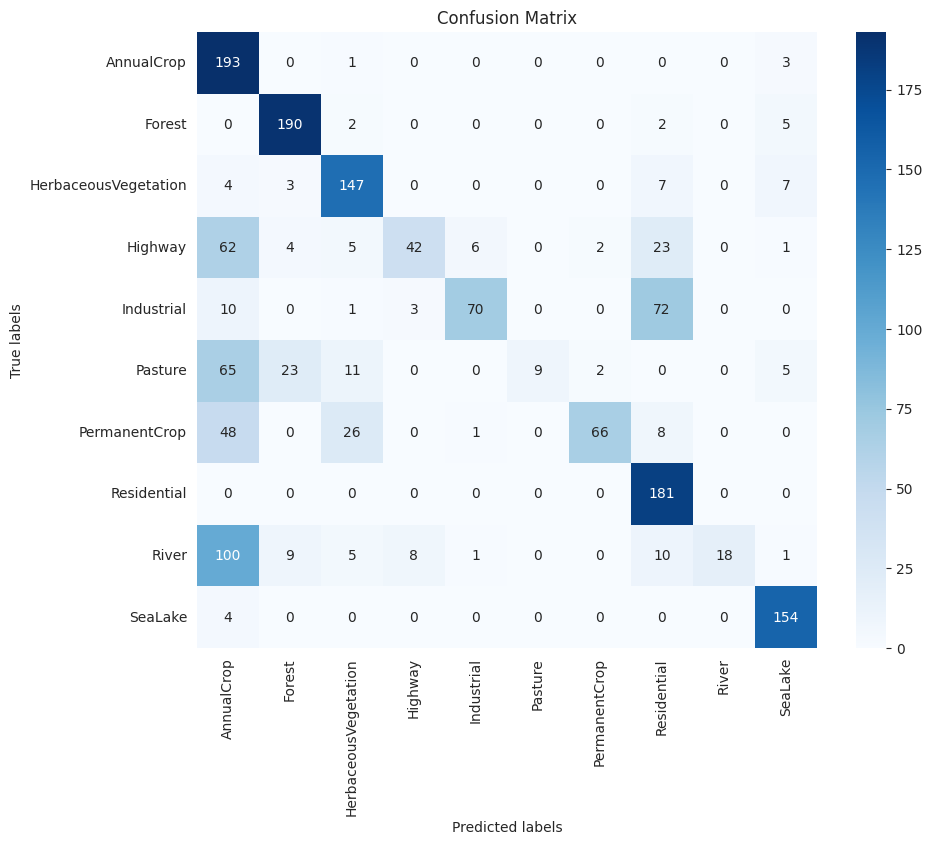

In [62]:
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

trainer.test(model_train, datamodule=data_module, ckpt_path=checkpoint_callback.best_model_path)

all_preds = np.concatenate(model_train.ep_out)
all_true = np.concatenate(model_train.ep_true)
true_ep = torch.tensor(all_true)
pred_ep = torch.tensor(all_preds)

metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)
metric.update(pred_ep, true_ep)
confmat = metric.compute()
confmat_np = confmat.numpy()
tick_labels = [encoder.categories_[0][i] for i in range(NUM_CLASSES)]

plt.figure(figsize=(10, 8))
sns.heatmap(confmat_np, annot=True, fmt='g', cmap='Blues', 
            xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tabulate import tabulate
from src.training.pretrainedModels import EuroSatPreTrainedModel
from datetime import datetime
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import BackboneFinetuning, ModelCheckpoint
from pytorch_lightning import Trainer
from src.training.data import EuroSatDataModule
import random
import numpy as np
import wandb

n_rounds = 20
gamma = 0.95
momentum = 0.9
dropout = 0.5
weight_decay = 5e-3

layers_samples = [[], [256]]

lr_samples = [0.3, 0.1, 0.05, 0.01]

bs_samples = [32, 64, 128]

param_space = [[l, b, la] for l in lr_samples for b in bs_samples for la in layers_samples]
random.shuffle(param_space)

out_table = []

for i in range(n_rounds):
    lr_hp, bs_hp, layers_hp = param_space[i]
    
    print(f"{c.OKBLUE}Round {i+1}/{n_rounds}{c.ENDC}")
    print(f"{c.OKBLUE}Learning Rate: {lr_hp:.4f}, Batch Size: {bs_hp}, Layers: {layers_hp}{c.ENDC}")
    
    data_module = EuroSatDataModule(ds_train, ds_val, ds_test, bs_hp)
    
    model = get_pretrained_model(PRETRAINED_MODEL)
    model_train = EuroSatPreTrainedModel(
        backbone=model,
        layers=layers_hp,
        learning_rate=lr_hp,
        gamma=gamma,
        momentum=momentum,
        dropout=dropout,
        weight_decay=weight_decay
    )
    
    checkpoint_callback = ModelCheckpoint(
        dirpath=CKPT_PATH + "hp_tuning" + f"/round_{i}",
        filename=f"bs_{bs_hp}_lr_{lr_hp}_ly_{layers_hp}_loss_" + '{val_loss:.2f}',
        save_top_k=1, 
        monitor="val_loss",
        verbose=False
    )

    wandb_logger = WandbLogger(
        project="eurosat_resnet",
        name=f"bs_{bs_hp}_lr_{round(lr_hp, 4)}_ly_{len(layers_hp)}",
        log_model=False,
    )

    trainer = Trainer(
        max_epochs=2,
        accelerator="gpu", 
        devices=1,
        logger=wandb_logger,
        callbacks=[checkpoint_callback],
    )

    trainer.fit(model_train, datamodule=data_module)
    trainer.test(model_train, datamodule=data_module, ckpt_path=checkpoint_callback.best_model_path, verbose=False)
    score = model_train.accuracy
    out_table.append([lr_hp, bs_hp, layers_hp, score])
    print(tabulate(out_table, headers=["Learning Rate", "Batch Size", "Layers", "Accuracy"]))
    wandb.finish()
    
print(tabulate(out_table, headers=["Learning Rate", "Batch Size", "Layers", "Accuracy"]))

# Predict on the test set

In [63]:
from src.datasets.EuroSatTest import EuroSatTestSet
from torch.utils.data import DataLoader
from config import Config

config = Config()

CHANNELS = [3, 2, 1]
_, transform = get_pretrained_model(PRETRAINED_MODEL)

mean_std_S2A = {
    'mean': [1307.6, 1151.7, 889.6],
    'std': [1375.2, 1188.1, 1159.1]
}

dataset = EuroSatTestSet(config.TEST_MS_DIR, select_chan=CHANNELS, add_B10=False, mean_std=mean_std_S2A, transform=transform) #, augment=augmentation)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)



Preloading images...
Number of images: 4232
Number of jobs:   -4 

Time taken:      0 min 9.219064235687256 sec 


In [67]:
from src.training.pretrainedModels import EuroSatPreTrainedModel
from src.training.cnn import LitEuroSatCnn
from config import Config
from src.training.pretrainedModels import get_pretrained_model

config = Config()

# model_eval = LitEuroSatCnn.load_from_checkpoint(
#     "checkpoints/cnn/14-18/cnn_c87654_k53_lr0.03_m0.9_g0.8epoch=09-val_loss=0.68.ckpt", #checkpoint_callback.best_model_path,
#     num_classes=NUM_CLASSES,
#     learning_rate=0.025, 
#     num_channels=len(CHANNELS), 
#     kernel_size=[5, 3],
#     momentum=0.9,
#     gamma=0.9,
#     weights=torch.tensor(w, dtype=torch.float32)
# )
model, _ = get_pretrained_model(PRETRAINED_MODEL)
model_eval = EuroSatPreTrainedModel.load_from_checkpoint(
    "checkpoints/resnet50_RGB_MOCO/18-59/epoch=00-val_loss=2.07.ckpt", #checkpoint_callback.best_model_path,
    backbone=model,
    learning_rate=1e-4,
    layers=[],
    momentum=0.9,
    dropout=0,
    weight_decay=0.0001
)

model_eval.eval()

EuroSatPreTrainedModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256,

In [68]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_eval = model_eval.to(device)
model_eval.eval()

N_CLASSES = 10
categorys = dataset.enc.categories_[0]
print(categorys)

predictions = []
probabilities = []
ohe = []
images = []
sample_ids = []

    
with torch.no_grad():
    for batch in dataloader:
        inputs, samp_id = batch
        inputs = inputs.to(device)
            
        outputs = model_eval(inputs)
        _, preds = torch.max(outputs, 1)
        
        preds = np.array(preds.cpu().numpy())
        
        pred_labels = np.array([categorys[p] for p in preds])
        
        predictions.extend(pred_labels)
        images.extend(inputs.cpu())
        sample_ids.extend(samp_id.cpu())
    


['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


In [69]:
import pandas as pd

sub_df = pd.DataFrame({'test_id': np.array(sample_ids), 'label': np.array(predictions)})
sub_df = sub_df.sort_values(by='test_id')
print(sub_df.head())
print(np.array(sample_ids))

sub_df.to_csv('submission_e0.csv', index=False)
print(np.unique(predictions, return_counts=True))

      test_id                 label
2229        0            AnnualCrop
344         1           Residential
2400        2                Forest
845         3               SeaLake
1131        4  HerbaceousVegetation
[3649 3353 2285 ...  310 1912 3893]
(array(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
       'Industrial', 'PermanentCrop', 'Residential', 'River', 'SeaLake'],
      dtype='<U20'), array([1664,  465,  342,   37,   57,    8,  647,    1, 1011]))


In [56]:
from torch.nn.functional import interpolate

# [ 606,  550,  229,  628,  216,  182,  280,  447,   89, 1005]
# [ 876,  601,  219,  582,  195,   55,  164,  458,   63, 1019]
def overlay_cam_on_image(im, cam_mask):
    cam_mask = (cam_mask - cam_mask.min()) / (cam_mask.max() - cam_mask.min())
    print(cam_mask.shape)

    print(im.shape)
    # Resize the CAM mask to match the image size
    cam_mask = interpolate(cam_mask, size=im.shape, mode='nearest').squeeze(0)
    print(im.shape)
    print(cam_mask.shape)
    # Convert CAM mask to heatmap
    heatmap = plt.get_cmap('jet')(cam_mask.cpu().detach().numpy())[:, :, :3]  # Get the RGB part, discard alpha
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float()

    # Overlay the heatmap on the image
    combined_img = heatmap * 0.3 + im.cpu() * 0.5  # Adjust opacity as needed

    return combined_img

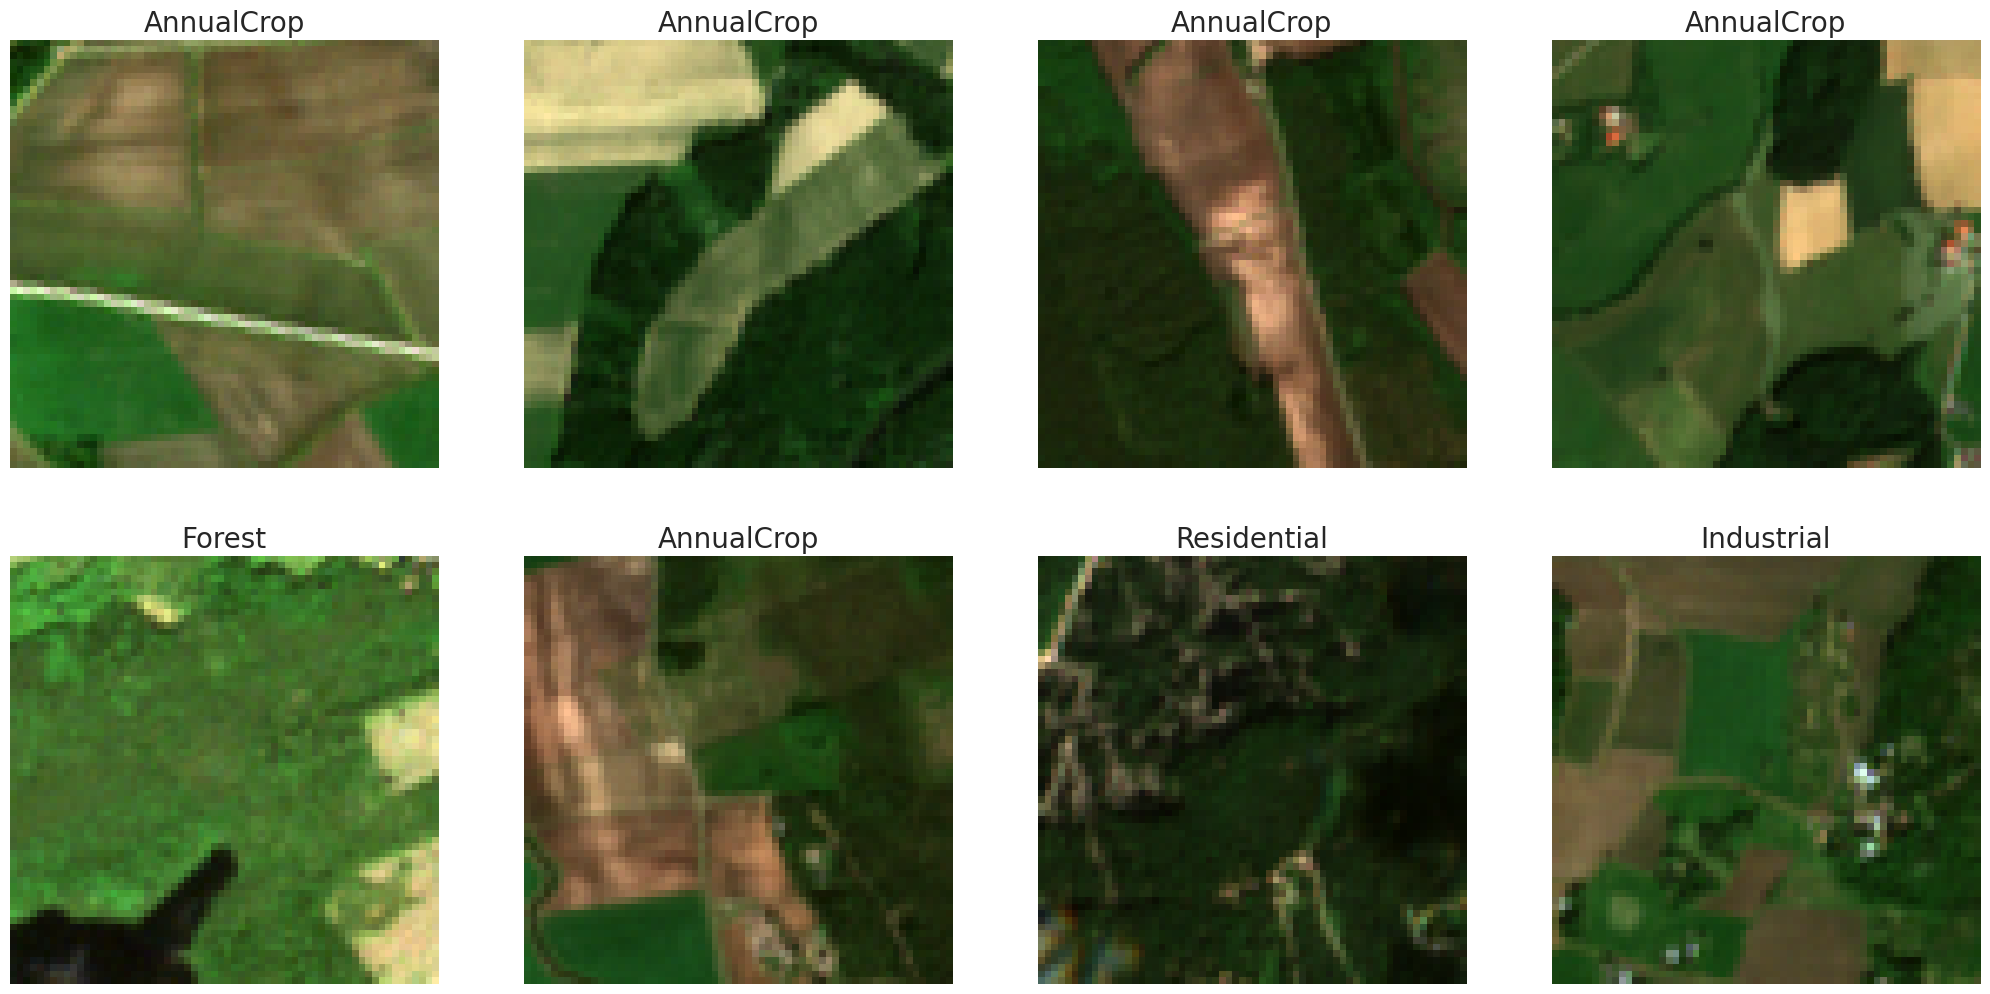

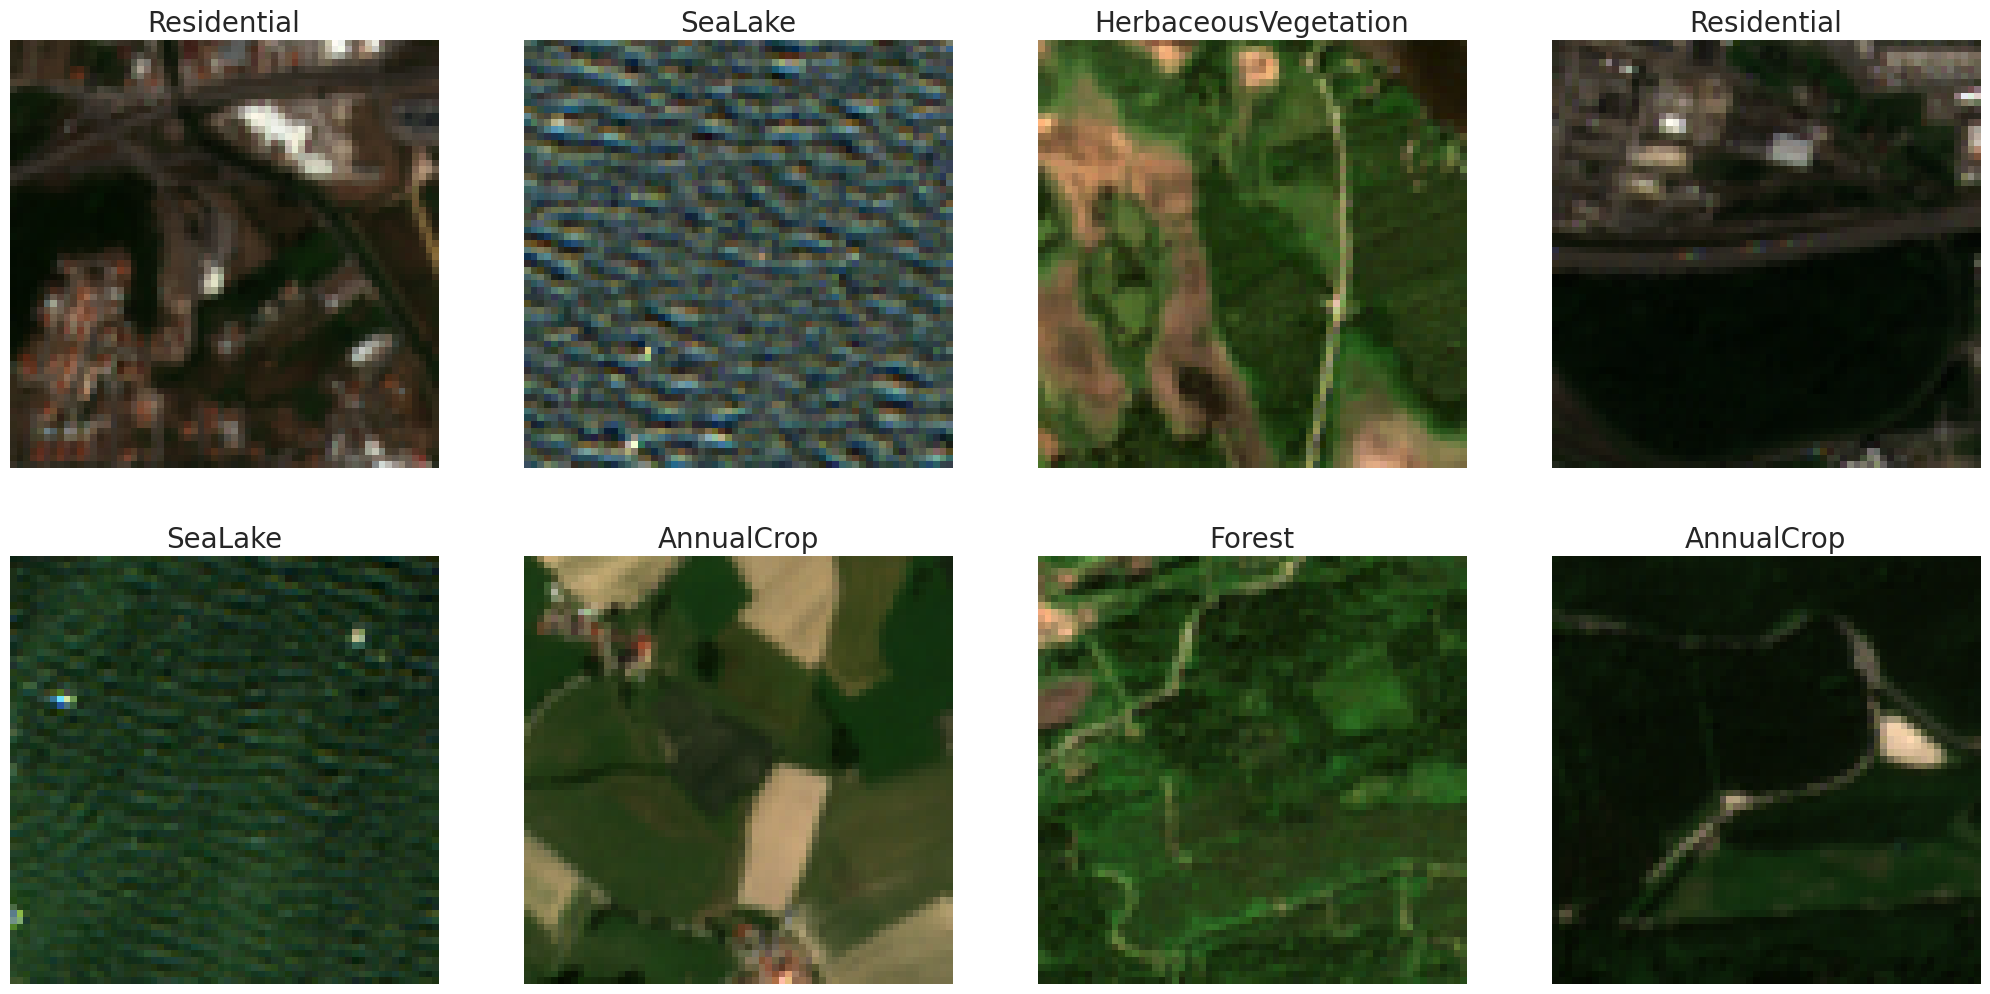

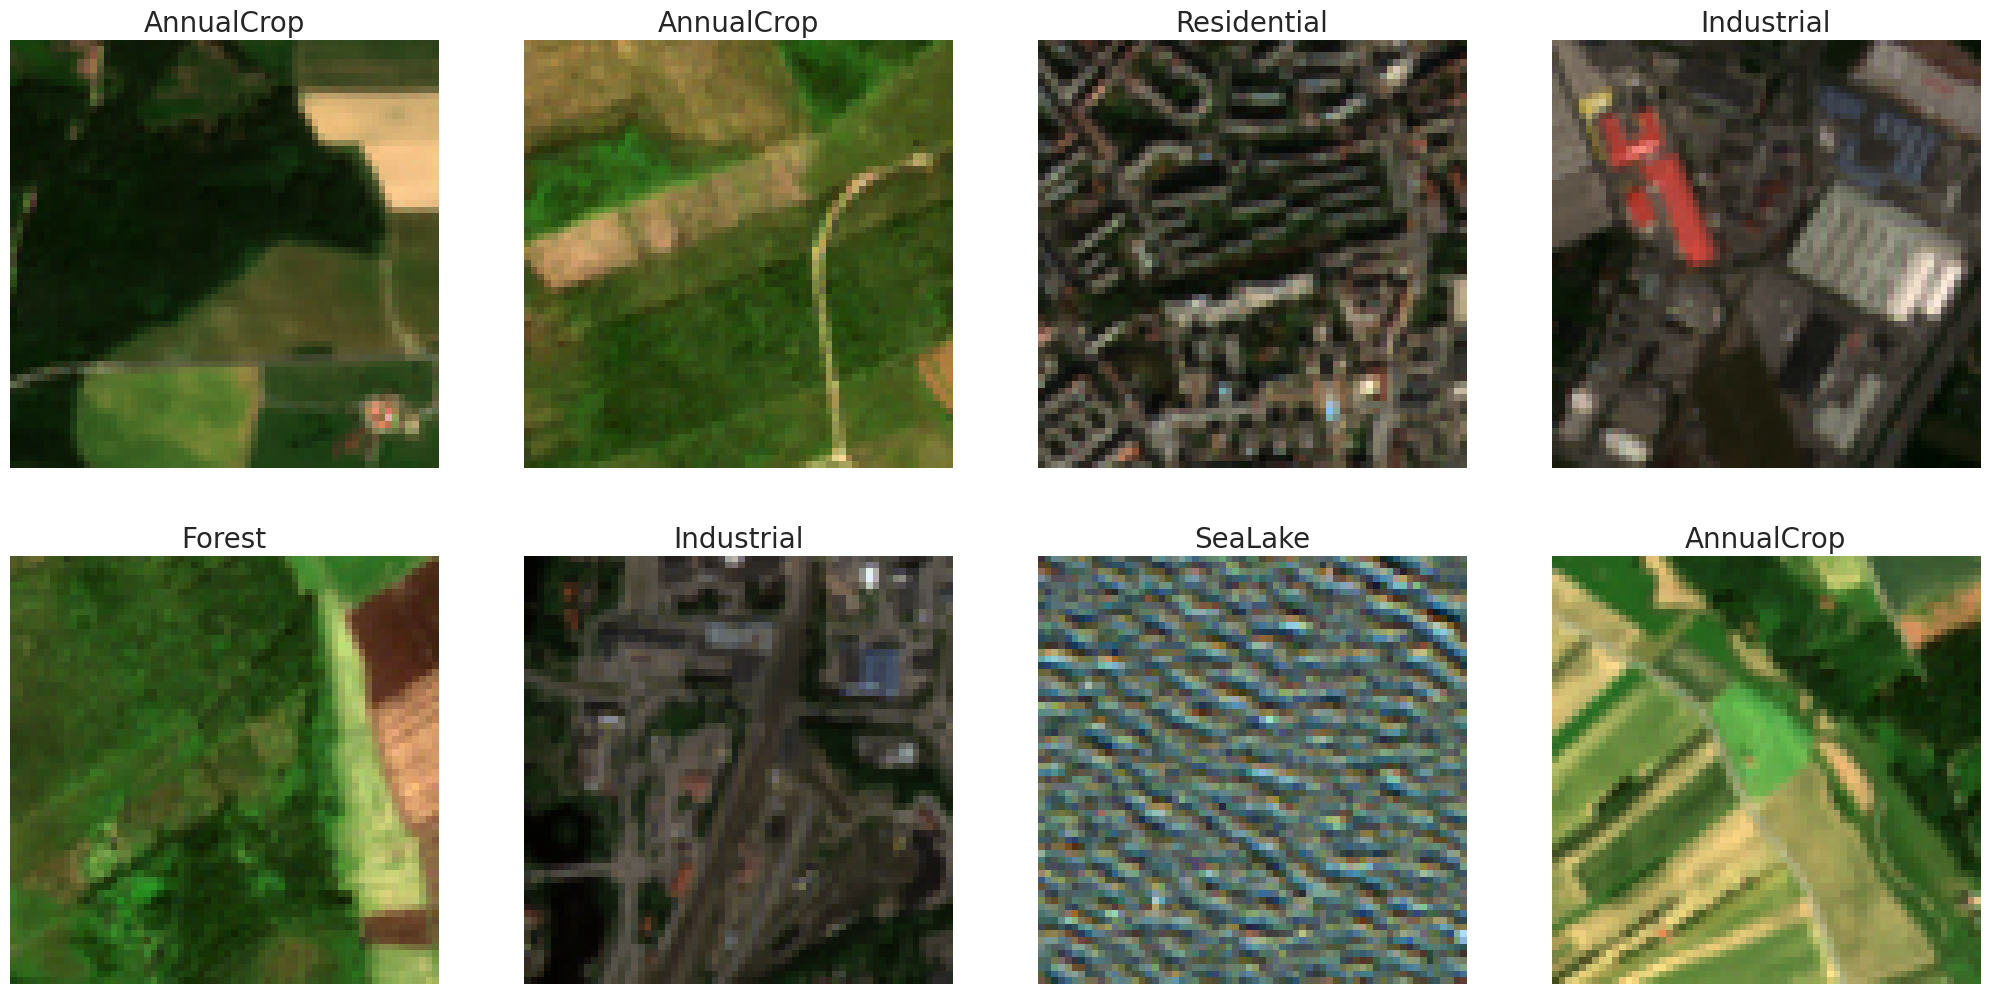

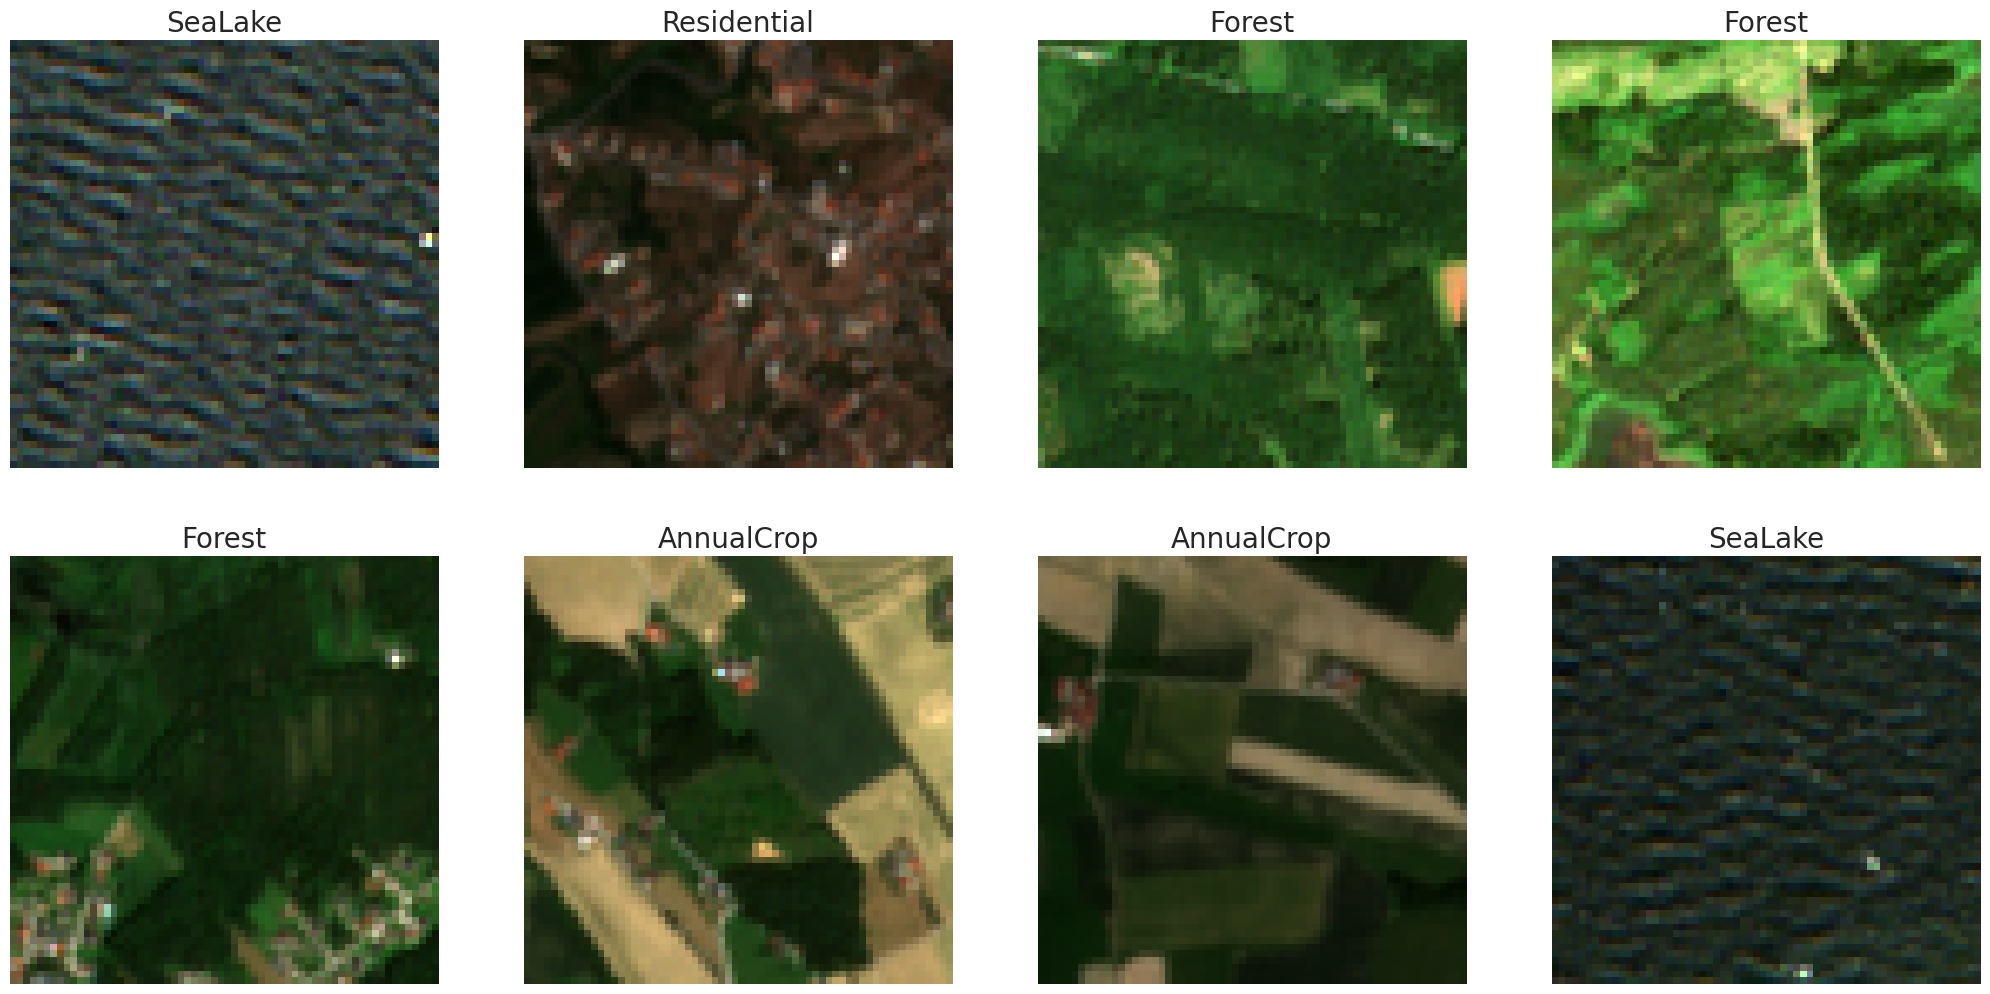

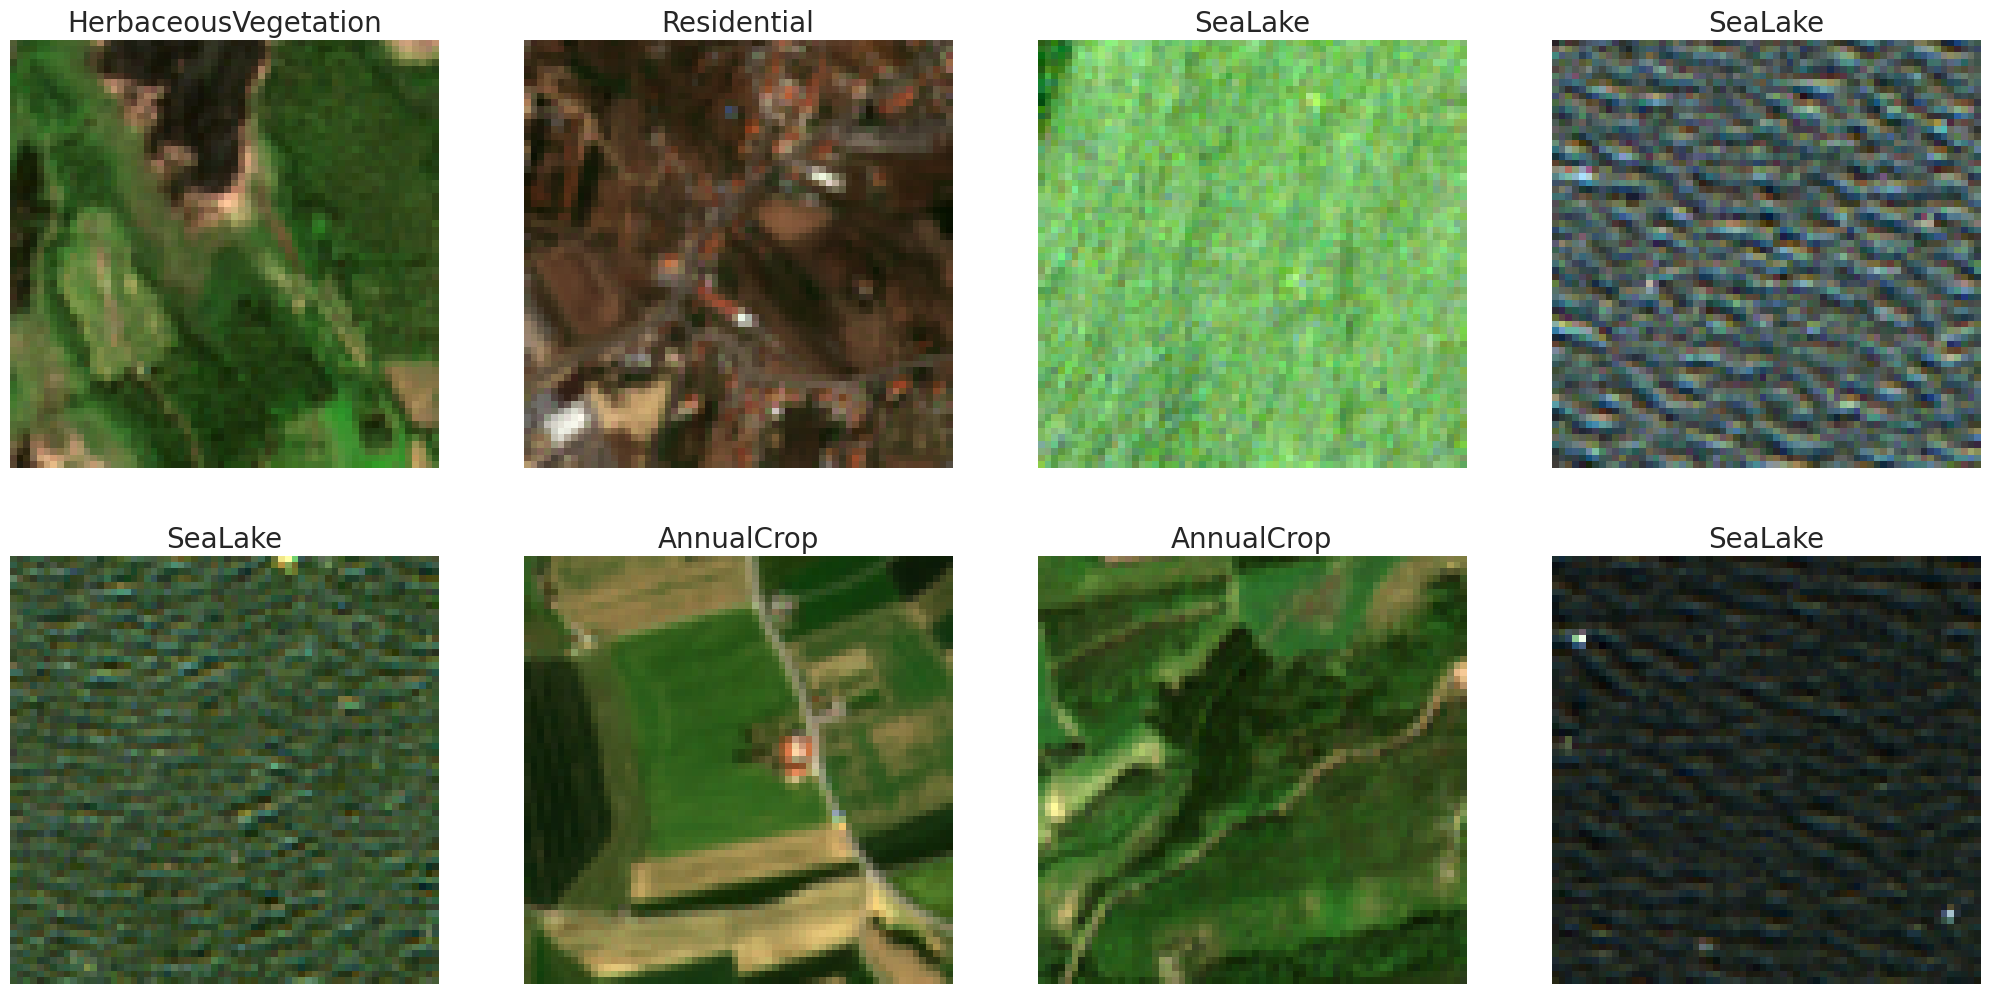

In [32]:
from pytorch_grad_cam import GradCAM

import torch
import random
from matplotlib import pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_cam_c = False
samp_batch_idx = [i for i in range(0, len(sample_ids))]
random.shuffle(samp_batch_idx)
samp_batch_idx = np.array(samp_batch_idx)
n = 5

for param in model_eval.backbone.parameters():
    param.requires_grad = True


# target_layer = [model_eval.backbone.layer4[-1].conv1]


for batch_start in range(0, n*8, 8):  # Iterate in steps of 8
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Create a new figure for each batch
    axs = axs.flatten()  # Flatten the grid for easy iteration

    for idx, ax in zip(samp_batch_idx[batch_start:batch_start+8], axs):
        pred = predictions[idx]
        samp_id = sample_ids[idx]
        
        im_path = config.DATA_DIR + f"test/NoLabel/test_{samp_id}.npy"
        # img = images[idx].unsqueeze(0).requires_grad_(True).to(device)
        img = np.load(im_path).transpose(2, 0, 1)
        img = img[[3, 2, 1]].astype(np.float32)
        
        rgb_min, rgb_max = img.min(), img.max()
        img = (img - rgb_min) / (rgb_max - rgb_min)
        img = img.clip(0, 1)
        
        
        if grad_cam_c:
            pass
            # img = images[idx].unsqueeze(0).requires_grad_(True).to(device)
            # cam = GradCAM(model=model_eval, target_layers=target_layer)
            # grayscale_cam = cam(input_tensor=img, targets=None)
            # cam_mask_tensor = torch.tensor(grayscale_cam).unsqueeze(0)
            # ax.imshow(cam_mask_tensor.squeeze(0).squeeze(0).cpu().numpy(), cmap='jet', alpha=0.1)
        else:
            ax.imshow(img.transpose(1, 2, 0))
        ax.set_title(pred, fontsize=20)
        ax.axis('off')
        

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()